# Corporate Tax Rates and the Largest Stock Exchanges

# ETL

### Import Utils

# *Globalization Analysis in the World Largest Economies*

This project is intended to analyze the progression of globalization since the 
end of the cold war using three key metrics: GDP, Unemployment Rate, and Inflation
Rate.

# ETL
We begin by adding in the required modules for the project and loading in our 
data sourced from yahoo finance, and the world bank.

### Import Utils

In [478]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

sns.set_theme()

from sklearn.linear_model import LinearRegression

### Import Data

Import corporate tax rates, inflation, and unemployment sourced from yahoo finance and the world bank.

In [479]:
corporate_tax_rates = pd.read_excel('../data/corporate.tax.rates.xlsx')
inflation_rates     = pd.read_csv('../data/inflation.csv')
unemployment_rates  = pd.read_csv('../data/unemployment rate.csv')

Now that the datasets have been turned into dataframes, we can prepare the data
for analysis.

# Data Preperation

The goal of this section is to prepare the following dataframes to be merged into one unified dataframe, which will be used for our analysis. This will entail removing unecessary columns and null data values, and filtering for only the countries we plan to analyze. Additionally, we will add columns for rate of change, for time series analysis.

## Corporate Tax Rates and GDP Data Quality Check and Tranformation

First, we check to make sure that the data was imported correctly.

In [480]:
corporate_tax_rates.head()

,iso_2,iso_3,continent,country,year,rate,gdp,oecd,eu27,gseven,gtwenty,brics
0,AW,ABW,NO,Aruba,1980,NaN,NaN,0,0,0,0,0
1,AW,ABW,NO,Aruba,1981,NaN,NaN,0,0,0,0,0
2,AW,ABW,NO,Aruba,1982,NaN,NaN,0,0,0,0,0
3,AW,ABW,NO,Aruba,1983,NaN,NaN,0,0,0,0,0
4,AW,ABW,NO,Aruba,1984,NaN,NaN,0,0,0,0,0


Next, we filter the `corporate tax rates` data removing country grouping data, 
and keeping only our chosen countries. We also want to add a column for 
`gdp_change`. To get the rate of change we use pandas build in `pct_change()`.

In [481]:
corporate_tax_rates = corporate_tax_rates.drop( columns=['iso_2','iso_3','continent','oecd','eu27','gseven','gtwenty','brics', 'rate'] )

country_list = [ 'United States of America', 'United Kingdom of Great Britain and Northern Ireland','Germany', 'Japan','China' ]

filtered_corporate_tax_rates = corporate_tax_rates[corporate_tax_rates['country'].isin(country_list)]

ctr = filtered_corporate_tax_rates

ctr['country'] = ctr['country'].replace({
  'United States of America': 'United States',
  'United Kingdom of Great Britain and Northern Ireland': 'United Kingdom',
})

# get percentage change yoy for gdp (for timeseries)
ctr['gdp_change'] = ctr['gdp'].pct_change()

print(ctr.shape)

(205, 4)


<ipython-input-481-23e9bfa62bb6>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ctr['country'] = ctr['country'].replace({
<ipython-input-481-23e9bfa62bb6>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ctr['gdp_change'] = ctr['gdp'].pct_change()


Finally, we check for missing values in `corporate_tax_rates`.

In [482]:
# drop missing data
ctr_na = ctr.loc[ ctr.isnull().any(axis=1) ]

ctr_na.head()

,country,year,gdp,gdp_change
1804,China,1980,341.361816,NaN


We then remove the rows that contained missing values, cutting all before 1981 
given the missing value above. We also make sure that the data types make sense.

In [483]:
ctr = ctr.loc[ ctr['year'] >= 1981 ]

ctr = ctr.astype({
  'year':'int32',
  'gdp':'float64',
  'gdp_change':'float64'
})

ctr.head()

,country,year,gdp,gdp_change
1805,China,1981,359.018463,0.051724
1806,China,1982,391.094727,0.089344
1807,China,1983,433.470673,0.108352
1808,China,1984,499.094574,0.151392
1809,China,1985,566.189819,0.134434


Given that there are missing value in the 80's. This decade will be ignored. With `ctr` containing only datapoints we want, it is ready to be merged into our unified dataframe.

## Inflation Rates Data Quality Check and Tranformation

First, we look at inflation rates data to make sure it was imported properly.

In [484]:
inflation_rates.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,Aruba,ABW,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG,NaN,NaN,NaN,NaN,NaN,NaN,...,4.316297,0.627472,-2.372065,0.421441,0.474764,-0.931196,-1.028282,3.626041,4.257462,NaN
1,Africa Eastern and Southern,AFE,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG,NaN,NaN,NaN,NaN,NaN,NaN,...,8.971206,9.158707,5.746949,5.370290,5.250171,6.594604,6.399343,4.720811,3.923372,4.978097
2,Afghanistan,AFG,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG,NaN,NaN,NaN,NaN,NaN,NaN,...,11.804186,6.441213,7.385772,4.673996,-0.661709,4.383892,4.975952,0.626149,2.302373,NaN
3,Africa Western and Central,AFW,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG,NaN,NaN,NaN,NaN,NaN,NaN,...,4.018699,4.578375,2.439201,1.758052,2.130268,1.494564,1.764635,1.481021,1.758565,2.425007
4,Angola,AGO,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG,NaN,NaN,NaN,NaN,NaN,NaN,...,13.482468,10.277905,8.777814,7.280387,9.150372,30.695313,29.843587,19.628608,17.081215,NaN


Next, we filter inflation rates data removing columns that don't include data that we need like `Country Code`, `Indicator Name`, and `Indicator Code`.

In [485]:
country_list = ['United States','United Kingdom','Germany', 'Japan','China' ]

filtered_inflation_rates = inflation_rates[ inflation_rates['Country Name'].isin(country_list) ]

ir = filtered_inflation_rates.drop( columns=['Country Code', 'Indicator Name', 'Indicator Code'] )

ir.head()

,Country Name,1960,1961,1962,1963,1964,1965,1966,1967,1968,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
40,China,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.553899,2.619524,2.621050,1.921642,1.437024,2.000002,1.593136,2.074790,2.899234,2.419422
55,Germany,1.536612,2.293676,2.843280,2.966961,2.335728,3.242329,3.533059,1.796046,1.470304,...,2.075175,2.008491,1.504721,0.906798,0.514421,0.491749,1.509497,1.732168,1.445667,0.506690
81,United Kingdom,1.003576,3.447496,4.196499,2.018544,3.281587,4.773775,3.909618,2.482116,4.697428,...,3.856112,2.573235,2.291667,1.451120,0.368047,1.008417,2.557756,2.292840,1.738105,0.989487
119,Japan,3.574512,5.368462,6.835440,6.706906,3.800389,6.655991,5.040832,3.989848,5.339433,...,-0.267634,-0.051939,0.346440,2.761954,0.789518,-0.116667,0.467212,0.979904,0.476974,-0.016369
251,United States,1.457976,1.070724,1.198773,1.239669,1.278912,1.585169,3.015075,2.772786,4.271796,...,3.156842,2.069337,1.464833,1.622223,0.118627,1.261583,2.130110,2.442583,1.812210,1.233584


Finally, we check to see if there is any missing data. `axis` is set to 0 for this
opperation since the data is in wide form.

In [486]:
ir_na = ir.loc[ :, ir.isnull().any(axis=0) ]

ir_na.head()

,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,...,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986
40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55,1.536612,2.293676,2.843280,2.966961,2.335728,3.242329,3.533059,1.796046,1.470304,1.912664,...,3.734168,2.718691,4.043622,5.441056,6.344241,5.241047,3.293415,2.405795,2.066231,-0.129413
81,1.003576,3.447496,4.196499,2.018544,3.281587,4.773775,3.909618,2.482116,4.697428,5.446664,...,15.840267,8.263141,13.421280,17.965924,11.876627,8.598864,4.609303,4.960711,6.071394,3.427609
119,3.574512,5.368462,6.835440,6.706906,3.800389,6.655991,5.040832,3.989848,5.339433,5.249821,...,8.161827,4.209566,3.701851,7.778582,4.912163,2.741041,1.899720,2.261614,2.032277,0.595587
251,1.457976,1.070724,1.198773,1.239669,1.278912,1.585169,3.015075,2.772786,4.271796,5.462386,...,6.501684,7.630964,11.254471,13.549202,10.334715,6.131427,3.212435,4.300535,3.545644,1.898048


We then remove rows with missing data and convert to tall form using `melt` for
easier calculations. The column `inflation_change` is added, which gives the 
change rate between years.

In [487]:
ir = ir.loc[ :, ir.isnull().any(axis=0) == False ]

years = ir.columns[1:]

ir = ir.melt( id_vars=['Country Name'], value_vars=years )
ir = ir.sort_values( by=['Country Name', 'variable' ] )
ir = ir.rename( columns={ 
  'Country Name':'country',
  'variable':'year', 
  'value':'inflation_rate'
})

ir = ir.astype({
  'year': 'int32',
  'inflation_rate': 'float64',
})

ir.head()

,country,year,inflation_rate,inflation_change
0,China,1987,7.233836,NaN
5,China,1988,18.811818,1.600532
10,China,1989,18.245638,-0.030097
15,China,1990,3.052290,-0.832711
20,China,1991,3.556686,0.165252


With `ir` containing only datapoints we want, it is ready to be merged into our unified dataframe.

## Unemployment Rates Data Quality Check and Transformation

First, we check that the data was imported successfully.

In [488]:
unemployment_rates.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,Aruba,ABW,"Unemployment, total (% of total labor force) (...",SL.UEM.TOTL.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Africa Eastern and Southern,AFE,"Unemployment, total (% of total labor force) (...",SL.UEM.TOTL.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,6.730720,6.578243,6.480673,6.414462,6.468598,6.546351,6.523061,6.414392,6.472269,6.814177
2,Afghanistan,AFG,"Unemployment, total (% of total labor force) (...",SL.UEM.TOTL.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,11.510000,11.520000,11.540000,11.450000,11.390000,11.310000,11.180000,11.060000,10.980000,11.730000
3,Africa Western and Central,AFW,"Unemployment, total (% of total labor force) (...",SL.UEM.TOTL.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,4.466731,4.560139,4.356187,4.640632,4.547113,5.486480,5.927104,5.910615,5.928926,6.300105
4,Angola,AGO,"Unemployment, total (% of total labor force) (...",SL.UEM.TOTL.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,7.360000,7.370000,7.380000,7.310000,7.260000,7.200000,7.100000,7.000000,6.930000,7.700000


Next, we narrow down our data to our selected countries.

In [489]:
country_list = ['United States', 'United Kingdom', 'Germany', 'Japan','China' ]

filtered_unemployment_rates = unemployment_rates[ unemployment_rates['Country Name'].isin(country_list) ]

ur = filtered_unemployment_rates.drop(columns=['Country Code', 'Indicator Name', 'Indicator Code'])

ur

,Country Name,1960,1961,1962,1963,1964,1965,1966,1967,1968,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
40,China,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.50,4.60,4.60,4.60,4.60,4.50,4.40,4.30,4.60,5.00
55,Germany,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.82,5.38,5.23,4.98,4.62,4.12,3.75,3.38,3.14,4.31
81,United Kingdom,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,8.04,7.89,7.52,6.11,5.30,4.81,4.33,4.00,3.74,4.34
119,Japan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.52,4.30,4.00,3.60,3.40,3.10,2.80,2.40,2.40,2.97
251,United States,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,8.95,8.07,7.38,6.17,5.28,4.87,4.36,3.90,3.67,8.31


Finally, check for any missing values

In [490]:
ur_na = ur.loc[ :, ur.isnull().any(axis=0) ]

ur_na.head()

,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,...,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990
40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
81,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
119,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
251,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Remove rows with missing values and conver to tall form using `melt`. The column
`unemployment_change` is added, which gives the change rate between years.

In [491]:
# remove missing values
ur = ur.loc[ :, ur.isnull().any(axis=0) == False ]

years = ur.columns[1:]

ur = ur.melt( id_vars=['Country Name'], value_vars=years )
ur = ur.sort_values( by=['Country Name', 'variable' ] )
ur = ur.rename( columns={ 
  'Country Name':'country',
  'variable':'year', 
  'value':'unemployment_rate'
})

ur['unemployment_change'] = ur['unemployment_rate'].pct_change()

ur = ur.astype({
  'year': 'int32',
  'unemployment_rate': 'float64',
  'unemployment_change': 'float64'
})

ur.head()

,country,year,unemployment_rate,unemployment_change
0,China,1991,2.4,NaN
5,China,1992,2.4,0.000000
10,China,1993,2.7,0.125000
15,China,1994,2.9,0.074074
20,China,1995,3.0,0.034483


With `ur` containing only datapoints we want, it is ready to be merged into our 
unified dataframe.

## Merge Dataframe

After `ctr`, `ur`, and `ir` have been properly cleaned and formatted, we unify the dataframes on the `country` and `year` columns using an inner join so only valid years are included.

In [492]:
df = ctr.merge(
  ur,
  on=['country', 'year'],
).merge(
  ir,
  on=['country', 'year']
)

df.head()

,country,year,gdp,gdp_change,unemployment_rate,unemployment_change,inflation_rate,inflation_change
0,China,1991,906.668762,0.092941,2.4,NaN,3.556686,0.165252
1,China,1992,1035.562256,0.142162,2.4,0.000000,6.353981,0.786489
2,China,1993,1179.169678,0.138676,2.7,0.125000,14.610079,1.299358
3,China,1994,1333.076782,0.130522,2.9,0.074074,24.256990,0.660292
4,China,1995,1479.038330,0.109492,3.0,0.034483,16.791225,-0.307778


We can see that there is a missing value in 1991 so we check for others.

In [493]:
print(df.isnull().any().sum())

1


Since that is the only missing value in the dataframe will remove 1991.

In [494]:
df = df[ df['year'] != 1991 ]

print(df.isnull().any().sum())

df.head()

0


,country,year,gdp,gdp_change,unemployment_rate,unemployment_change,inflation_rate,inflation_change
1,China,1992,1035.562256,0.142162,2.4,0.000000,6.353981,0.786489
2,China,1993,1179.169678,0.138676,2.7,0.125000,14.610079,1.299358
3,China,1994,1333.076782,0.130522,2.9,0.074074,24.256990,0.660292
4,China,1995,1479.038330,0.109492,3.0,0.034483,16.791225,-0.307778
5,China,1996,1625.882690,0.099284,3.1,0.033333,8.313160,-0.504910


With the merge successful, we can now perform some exploratory analysis.

Aside: We export our unified dataframe `df` into a .csv named `../data/econ_data.csv` so that we can create our dashboard.

In [495]:
# export for use in dashboard
df.to_csv('../data/econ_data.csv')

# Data Exploration

The purpose of this section is to visualize the variables to be analyzed in our time series analysis.

## Plotting Utilities
To make EDA easier we developed two plotting utilities. One for line plots and
one for distribution plots (seabords swarm plot). These will be used for our 
dashboard aswell.

The first `line_plot` creates a line plot of each country in the dataframe. The 
`values` are the metric to be assesed, the `index` is the x axis.

In [496]:
def line_plot( df, values, index ):
  fig, ax = plt.subplots()

  countries = df['country'].unique()
  
  for country in countries:
    filt_df = df[ df['country'] == country ]
  
    ax.plot( filt_df[index], filt_df[values], label=country )

  ax.set_xlabel(index)
  ax.set_ylabel(values)

  fig.suptitle( values + ' vs ' + index )
  fig.set_size_inches( 10, 6 )

  ax.legend()

  plt.show()

The second `swarmplot` creates a seabord swarmplot with the same params as 
`line_plot`.

In [497]:

def swarmplot( df, values, index ):
  fig, ax = plt.subplots()

  fig.suptitle( values + ' vs ' + index )
  fig.set_size_inches( 10, 6 )

  sns.swarmplot( ax=ax, x='country', y=values, data=df )

  ax.set_xlabel(index)
  ax.set_ylabel(values)

  plt.show()

## GDP vs Year

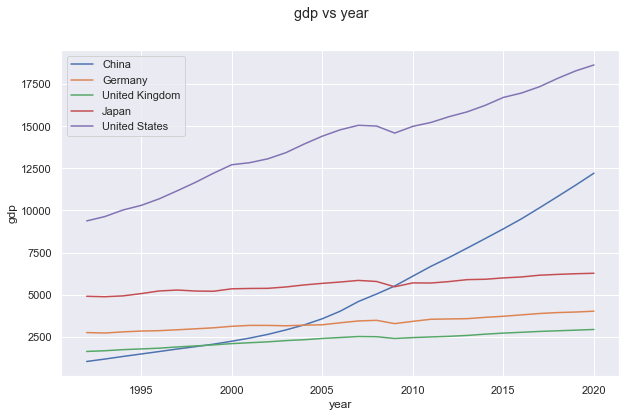

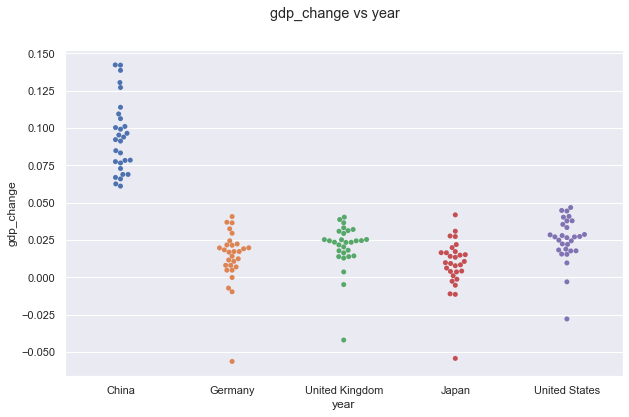

In [498]:
line_plot( df, 'gdp', 'year' )
swarmplot( df, 'gdp_change', 'year' )

From the plot we see that the growth rate of developed economies is slower than
that of China. However, the US maintains a strong growth rate. In addition, the
2008 crisis appears to have had almost no impact on China in comparison to others.
In the distrubutions we see that the US is really only slightly higher then 
other developed nations while china is significantly ahead and also has greater
variation. Each of the developed countries also has one outlier for gdp change,
2008.

## Inflation Rate

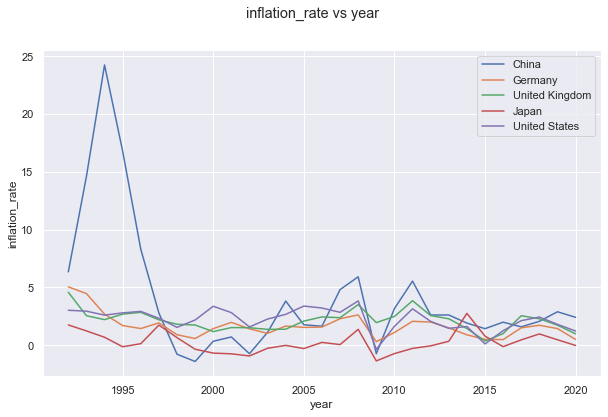

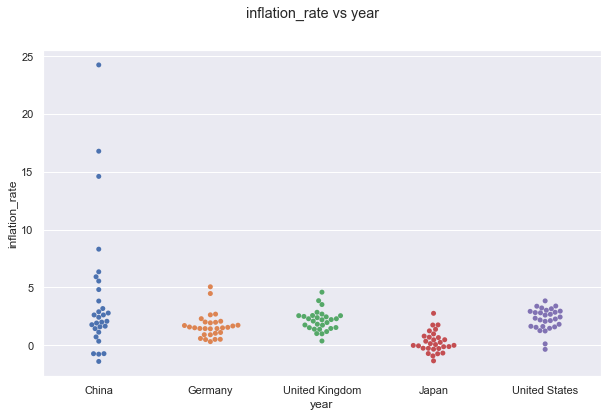

In [499]:
line_plot( df, 'inflation_rate', 'year' )
swarmplot( df, 'inflation_rate', 'year' )

Inflation tells a different story with countries remaining very close together.
Japan however, does show significant variation.

In [500]:
df_china_high_inf = df[ (df['country'] == 'China') & (df['inflation_change'] >= .10) ]

df_china_high_inf.head()

,country,year,gdp,gdp_change,unemployment_rate,unemployment_change,inflation_rate,inflation_change
1,China,1992,1035.562256,0.142162,2.4,0.000000,6.353981,0.786489
2,China,1993,1179.169678,0.138676,2.7,0.125000,14.610079,1.299358
3,China,1994,1333.076782,0.130522,2.9,0.074074,24.256990,0.660292
8,China,1999,2062.001953,0.076675,3.3,0.031250,-1.401473,0.812594
10,China,2001,2423.668945,0.083399,3.8,0.151515,0.719126,1.067574


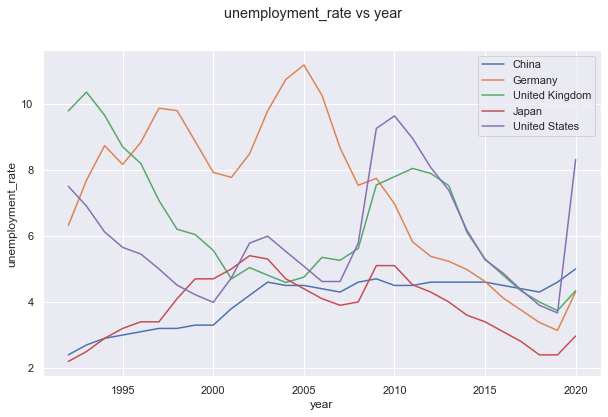

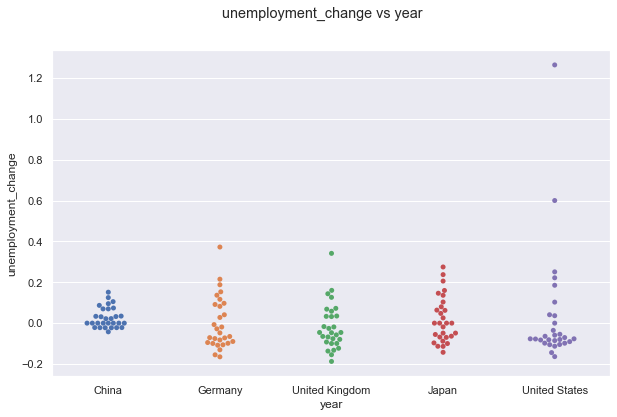

In [501]:
line_plot( df, 'unemployment_rate', 'year' )
swarmplot( df, 'unemployment_change', 'year' )

In terms of unemployment, countries stay primarily within the same range with
China remaining near constant. The US shows that is is the most rective to 
economic turbulence in this regard with two significant increases 2009 and 2010 
as shown below.

In [502]:
df_us     = df[ df['country'] == 'United States' ]
df_us_inc = df_us[ df_us['unemployment_change'] > 0.4 ]

df_us_inc.head()

,country,year,gdp,gdp_change,unemployment_rate,unemployment_change,inflation_rate,inflation_change
138,United States,2009,14594.841797,-0.027755,9.25,0.600346,-0.355546,-1.092612
149,United States,2020,18637.896484,0.019000,8.31,1.264305,1.233584,-0.319293


# Globalization in GDP

Globalization has to do with the increasing interconnectedness of nations internationally. To investigate the rate of globalization, we will take data since 1994 from 5 nations in terms of gdp, inflation rate, and unemployment and see if the correlations between nations in terms of these variables are increasing.

We will use a timeseries correlation function to measure how our selected variables co-vary over time. The out put of this function will indicate a linear relationship as a number between -1 and 1. To do this, we first define the time periods to look at. 

We create the function `compute_ts_correlation` with inputs start_year, end_year, country_1, country_2, and metric. The purpose of this function is to perform the pearson time series correlation between 2 countries that are passed through the functions inputs.

In [503]:

def compute_ts_correlation( start_year, end_year, country_1, country_2, metric ):
  df_base = df.loc[(df['year'] >= start_year) & (df['year'] < end_year)]

  df_1 = df_base[ df_base['country'] == country_1 ]
  df_2 = df_base[ df_base['country'] == country_2 ]

  r, p = stats.pearsonr( df_1[metric], df_2[metric] )

  return r, p

With `compute_ts_correlation` defined, we are able to get the correlation `r` and p-value `p` as returns. These values will be used to asses if there is a correlation between countries. 

We defined the `compute_ts_block_correlation` function to constrain our time series analysis to just the time periods defined in `time_periods`.

In [504]:
def compute_ts_block_correlation( country_1, country_2, metric, time_periods ):
  outputs = []

  for period in time_periods:
    r, p = compute_ts_correlation( period[0], period[1], country_1, country_2, metric )

    outputs.append( [r, p] )
  
  return outputs

With `copmute_ts_block_correkation` defined, we get the correlations and p-values between chosen countries between every year defined in `time_periods`.

Next, we want to get the average correlation `r` for each time period. To do this, we create `def_average_correlations`.

In [505]:

def get_average_correlation( metric, countries, time_periods ):
  used_countries = []
  period_corrs = []
  avg_corrs = []

  for period in time_periods:
    period_corrs.append( [] )

  for country_1 in countries:
    used_countries.append( country_1 )

    for country_2 in countries:

      if country_2 in used_countries:
        continue

      if country_1 == country_2:
        continue

      outputs = compute_ts_block_correlation( 
        country_1, 
        country_2, 
        metric,
        time_periods
      )

      for i in range( 0, len(time_periods) ):
        period_corrs[i].append( abs(outputs[i][0]) )

  for period in period_corrs:
    total = 0

    for correlation in period:

      total += correlation

    avg_corrs.append( total / len(period) )

  return avg_corrs, period_corrs


With `get_average_correlations` defined, we can use these average correlations to understand if there was a high or low correlation between 2 countries for a selected 

The `time_periods` variable will be used in the `compute_ts_block_correation` function.

In [506]:
countries = [ 'China', 'Japan', 'United States', 'Germany', 'United Kingdom' ]

time_periods = [ 
  [ 1995, 2000 ], 
  [ 2000, 2005 ],
  [ 2005, 2010 ],
  [ 2010, 2015 ],
  [ 2015, 2020 ] 
]

avg_corr, corr = get_average_correlation( 'gdp_change', countries, time_periods )

print( avg_corr )

[0.6439075836155045, 0.45461279131073934, 0.8558467934218698, 0.33868699478552977, 0.5204886070869676]


To visualize these correlations we will use a lineplot. We will write another 
plotting function to help out, (also used in the dashboard).

In [507]:
def corr_line_plot( df, values, index, countries ):
  time_periods = [ 
    [ 1995, 2000 ], 
    [ 2000, 2005 ],
    [ 2005, 2010 ],
    [ 2010, 2015 ],
    [ 2015, 2020 ] 
  ]

  avg_corrs, corr = get_average_correlation( values, countries, time_periods )

  x = []
  y = avg_corrs

  for period in time_periods:
    x.append( str(period[0]) + '-' + str(period[1]) )
  
  fig, ax = plt.subplots()

  fig.suptitle( values + ' vs ' + index )
  fig.set_size_inches( 10, 6 )

  ax.plot( x, y )

  ax.set_xlabel(index)
  ax.set_ylabel(values)

  plt.ylim([0, 1])
  plt.show()

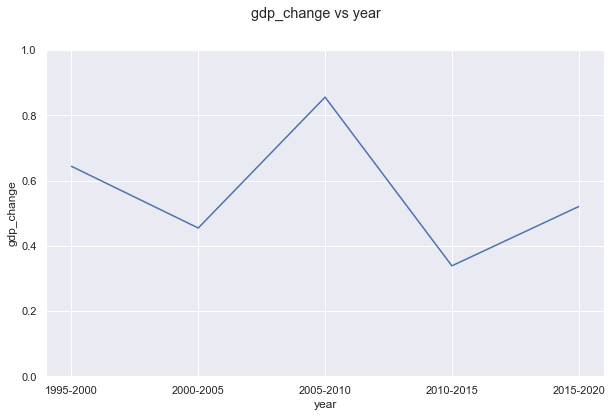

In [508]:
corr_line_plot( df, 'gdp_change', 'year', countries )

The plot shows that for all countries, correlations were very high between 2005
and 2010. This is likely due to the financial crysis. However, the correlations
appear to be in decline. This may show reduction in globalization.

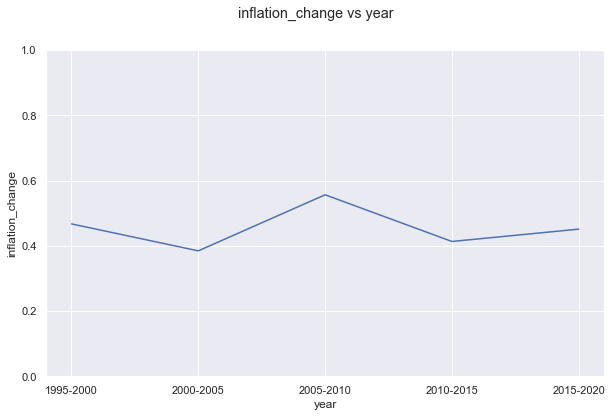

In [509]:
corr_line_plot( df, 'inflation_change', 'year', countries )

Inflation has remained relatively constant in terms of correlation but also at
a relatively low value. Indicating globalization, but no change.

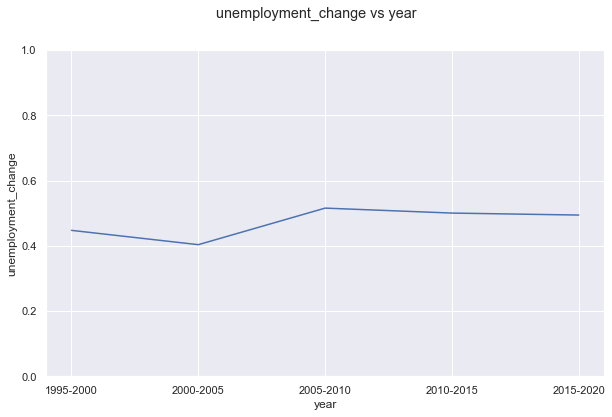

In [510]:
corr_line_plot( df, 'unemployment_change', 'year', countries )

Unemployment has also remained relatively constant also at a low level which
does not demonstrate increasing globalization.